In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.models import LinearRegression
from src.losses import MSE
from src.optimizers.gd import GD
from src.optimizers.adam import Adam
from src.regularizers import L1, L2, Elastic_Net

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
X, y = make_regression(
    n_samples=500, n_features=100, n_informative=5, noise=20, random_state=42
)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 100), (400,), (100, 100), (100,))

In [7]:
n_train = X_train.shape[0]
epochs = 500
lr = 0.01


def get_steps(batch_size, n_samples, epochs):
    if batch_size is None:
        return epochs
    else:
        return int((n_samples / batch_size) * epochs)


# Full Batch (GD)
model_none = LinearRegression(
    loss=MSE(),
    opt=GD(lr=lr),
    steps=get_steps(None, n_train, epochs),
    reg=None,
    batch_size=None,
)

# Mini-Batch 20 (SGD)
model_l1 = LinearRegression(
    loss=MSE(),
    opt=GD(lr=lr),
    steps=get_steps(20, n_train, epochs),
    reg=L1(alpha=5.0),
    batch_size=20,
    loss_smoothing=0.05,
)

# Mini-Batch 30
model_l2 = LinearRegression(
    loss=MSE(),
    opt=GD(lr=lr),
    steps=get_steps(30, n_train, epochs),
    reg=L2(alpha=0.05),
    batch_size=30,
    loss_smoothing=0.1,
)

# Mini-Batch 5
model_en = LinearRegression(
    loss=MSE(),
    opt=GD(lr=lr),
    steps=get_steps(5, n_train, epochs),
    reg=Elastic_Net(alpha=0.05, l1_ratio=0.5),
    batch_size=5,
    loss_smoothing=0.1,
)

# Adam + L1
model_adam = LinearRegression(
    loss=MSE(),
    opt=Adam(lr=1e-01, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    steps=get_steps(64, n_train, epochs),
    reg=L1(alpha=0.01),
    batch_size=64,
)

model_none.fit(X_train, y_train)
model_l1.fit(X_train, y_train)
model_l2.fit(X_train, y_train)
model_en.fit(X_train, y_train)
model_adam.fit(X_train, y_train)

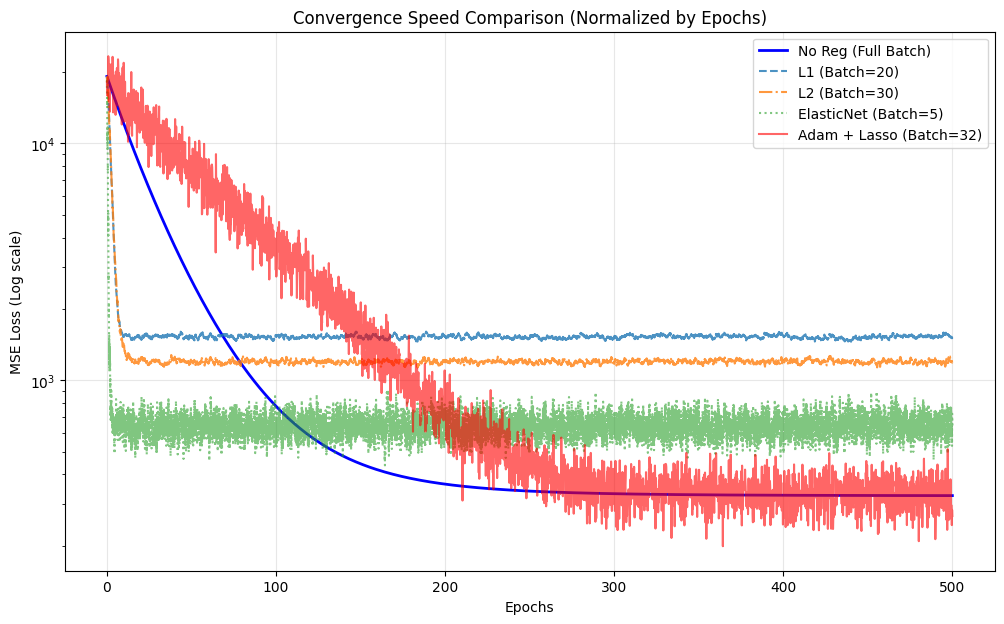

In [8]:
plt.figure(figsize=(12, 7))


def get_x_axis(history, epochs):
    return np.linspace(0, epochs, len(history))


plt.plot(
    get_x_axis(model_none.history, epochs),
    model_none.history,
    label="No Reg (Full Batch)",
    linewidth=2,
    color="blue",
)
plt.plot(
    get_x_axis(model_l1.history, epochs),
    model_l1.history,
    label="L1 (Batch=20)",
    linestyle="--",
    alpha=0.8,
)
plt.plot(
    get_x_axis(model_l2.history, epochs),
    model_l2.history,
    label="L2 (Batch=30)",
    linestyle="-.",
    alpha=0.8,
)
plt.plot(
    get_x_axis(model_en.history, epochs),
    model_en.history,
    label="ElasticNet (Batch=5)",
    linestyle=":",
    alpha=0.6,
)
plt.plot(
    get_x_axis(model_adam.history, epochs),
    model_adam.history,
    label="Adam + Lasso (Batch=32)",
    linestyle="solid",
    color="red",
    alpha=0.6,
)


plt.xlabel("Epochs")
plt.ylabel("MSE Loss (Log scale)")
plt.title("Convergence Speed Comparison (Normalized by Epochs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")
plt.show()

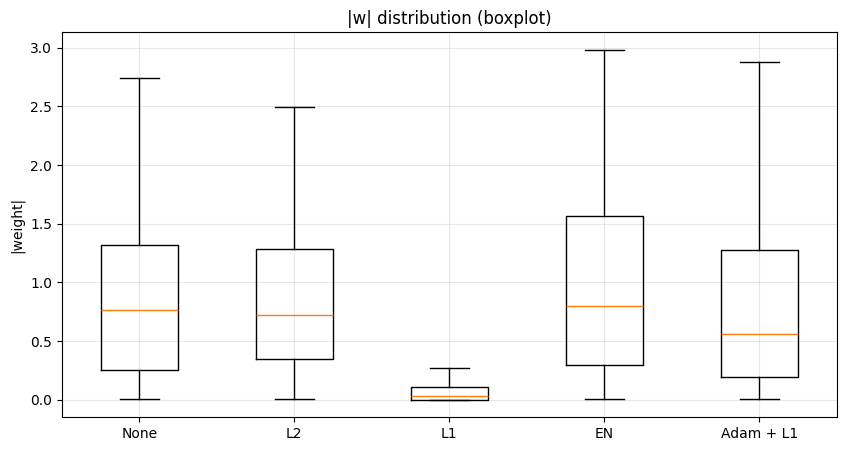

In [9]:
weights = {
    "None": np.abs(model_none.w[1:]),
    "L2": np.abs(model_l2.w[1:]),
    "L1": np.abs(model_l1.w[1:]),
    "EN": np.abs(model_en.w[1:]),
    "Adam + L1": np.abs(model_adam.w[1:]),
}

plt.figure(figsize=(10, 5))
plt.boxplot(
    list(weights.values()), tick_labels=list(weights.keys()), showfliers=False
)
plt.title("|w| distribution (boxplot)")
plt.ylabel("|weight|")
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
y_pred_none = model_none.predict(X_test)
y_pred_l1 = model_l1.predict(X_test)
y_pred_l2 = model_l2.predict(X_test)
y_pred_en = model_en.predict(X_test)
y_pred_adam = model_adam.predict(X_test)

print(f"None: {MSE()(y_test, y_pred_none)}")
print(f"L1 (Lasso): {MSE()(y_test, y_pred_l1)}")
print(f"L2 (Ridge): {MSE()(y_test, y_pred_l2)}")
print(f"Elastic-Net: {MSE()(y_test, y_pred_en)}")
print(f"Adam + Lasso: {MSE()(y_test, y_pred_adam)}")

None: 547.6842113201532
L1 (Lasso): 429.59018921832933
L2 (Ridge): 638.5599606563948
Elastic-Net: 635.9839891835129
Adam + Lasso: 529.7558686933111
